In [1]:
import pandas as pd

probs = pd.read_json("aspect_entailment_probabilities.json")
probs

,sequence,labels,scores
0,Shrimp roasted with vegetables in a zesty Ital...,"[shrimp, balanced diet]","[0.9963915348052971, 0.9231709837913511]"
1,Shrimp balls made with pork fat deep fried in oil,"[shrimp, balanced diet]","[0.90291154384613, 0.005868990905582]"
2,Breaded shrimp with whole milk and creole seas...,"[shrimp, balanced diet]","[0.9757009148597711, 0.39306277036666804]"
3,Cucumber sauce with fat-free yogurt and reduce...,"[balanced diet, shrimp]","[0.9392296075820921, 8.820796210784466e-05]"
4,Healthy napa cabbage and green onion coleslaw ...,"[balanced diet, shrimp]","[0.9921187162399291, 0.00011050567263700001]"
...,...,...,...
2495,Fish meat cooked on a grill / stovetop / oven,"[seafood, only have a bbq, eating dairy makes ...","[0.995876610279083, 0.002118620323017, 3.79707..."
2496,Fish meat cooked in a steamer,"[seafood, only have a bbq, eating dairy makes ...","[0.9986196756362911, 0.000332452327711, 2.4294..."
2497,Fish meat prepared with swiss cheese,"[seafood, eating dairy makes me sick, only hav...","[0.9940803647041321, 0.004660131875425, 0.0004..."
2498,Seafood linguine recipe containing shrimp,"[seafood, only have a bbq, eating dairy makes ...","[0.9984157681465141, 0.000328484253259, 7.7745..."


In [2]:
query_probs = pd.read_json("query_entailment_probabilities.json")
query_probs

,sequence,labels,scores
0,Shrimp roasted with vegetables in a zesty Ital...,[I would like a shrimp recipe and I'm trying t...,[0.890443801879882]
1,Shrimp balls made with pork fat deep fried in oil,[I would like a shrimp recipe and I'm trying t...,[0.064984962344169]
2,Breaded shrimp with whole milk and creole seas...,[I would like a shrimp recipe and I'm trying t...,[0.7555378675460811]
3,Cucumber sauce with fat-free yogurt and reduce...,[I would like a shrimp recipe and I'm trying t...,[0.001509124645963]
4,Healthy napa cabbage and green onion coleslaw ...,[I would like a shrimp recipe and I'm trying t...,[0.0007269414491020001]
...,...,...,...
2495,Salmon fillets grilled in a pan with herbs and...,[What are recipes for fish but not baked in th...,[0.9021332859992981]
2496,Baked halibut fish fillets with Worcestershire...,[What are recipes for fish but not baked in th...,[0.167374327778816]
2497,Breaded fish fillets baked with parmesan chees...,[What are recipes for fish but not baked in th...,[0.08219508081674501]
2498,Cheesy chicken breast halves skillet-cooked wi...,[What are recipes for fish but not baked in th...,[0.0012377836974330001]


In [3]:
recipe_mpr = pd.read_json('https://raw.githubusercontent.com/D3Mlab/Recipe-MPR/main/data/500QA.json', orient = 'records')

recipe_mpr_clean = (
    recipe_mpr
    .assign(
        query_aspects = lambda d: d.correctness_explanation.apply(lambda x: list(x.keys())),
        num_aspects = lambda d: d.query_aspects.apply(len),
        option_id = lambda d: d.options.apply(lambda x: list(x.keys())),
        option_text = lambda d: d.options.apply(lambda x: list(x.values()))
    )
    .query("num_aspects > 1")
    .explode(['option_id', 'option_text'])
    .assign(correct = lambda d: d.answer == d.option_id)
    [['query', 'query_aspects', 'option_id', 'option_text', 'correct']]
    .explode(['query_aspects'])
)

recipe_mpr_clean

,query,query_aspects,option_id,option_text,correct
0,I want to make a warm dish containing oysters,warm dish,08cb462fdf,Simple creamy oyster soup,True
0,I want to make a warm dish containing oysters,oysters,08cb462fdf,Simple creamy oyster soup,True
0,I want to make a warm dish containing oysters,warm dish,5b9441298f,Seasoned salted crackers shaped like oysters,False
0,I want to make a warm dish containing oysters,oysters,5b9441298f,Seasoned salted crackers shaped like oysters,False
0,I want to make a warm dish containing oysters,warm dish,00310c3462,Creamy clam chowder made with whole milk and b...,False
...,...,...,...,...,...
499,What's a good broccoli side dish I can make fo...,side dish,29500eb70f,Beef paired with bacon entree,False
499,What's a good broccoli side dish I can make fo...,loves meat,29500eb70f,Beef paired with bacon entree,False
499,What's a good broccoli side dish I can make fo...,broccoli,81e0d049d7,Broccoli cooked in the oven,False
499,What's a good broccoli side dish I can make fo...,side dish,81e0d049d7,Broccoli cooked in the oven,False


In [4]:
import numpy as np
def noisy_or(probs):
  return 1 - np.product(1 - probs)

query_item_scores = (
    probs
    .explode(['labels', 'scores'])
    .rename(columns = {'sequence': 'option_text', 'labels': 'query_aspects'})
    .merge(recipe_mpr_clean)
    .groupby(['query', 'option_text', 'correct'])
    ['scores']
    .agg(['min', 'max', 'prod', noisy_or, 'mean'])
    .reset_index()
    .rename(columns = {'prod': 'all', 'noisy_or': 'any'})
)

query_item_scores

,query,option_text,correct,min,max,all,any,mean
0,I would like a shrimp recipe and I'm trying t...,Breaded shrimp with whole milk and creole seas...,False,0.393063,0.975701,0.383512,0.985252,0.684382
1,I would like a shrimp recipe and I'm trying t...,Cucumber sauce with fat-free yogurt and reduce...,False,0.000088,0.93923,0.000083,0.939235,0.469659
2,I would like a shrimp recipe and I'm trying t...,Healthy napa cabbage and green onion coleslaw ...,False,0.000111,0.992119,0.00011,0.992120,0.496115
3,I would like a shrimp recipe and I'm trying t...,Shrimp balls made with pork fat deep fried in oil,False,0.005869,0.902912,0.005299,0.903481,0.45439
4,I would like a shrimp recipe and I'm trying t...,Shrimp roasted with vegetables in a zesty Ital...,True,0.923171,0.996392,0.91984,0.999723,0.959781
...,...,...,...,...,...,...,...,...
2495,Would I be able to get a breakfast recipe with...,Breakfast sausage made from scratch using pork...,False,0.000043,0.000892,0.0,0.000999,0.000333
2496,Would I be able to get a breakfast recipe with...,Fish meat cooked in a steamer,False,0.000024,0.99862,0.0,0.998620,0.332992
2497,Would I be able to get a breakfast recipe with...,Fish meat cooked on a grill / stovetop / oven,True,0.000038,0.995877,0.0,0.995886,0.332678
2498,Would I be able to get a breakfast recipe with...,Fish meat prepared with swiss cheese,False,0.000449,0.99408,0.000002,0.994111,0.333063


In [5]:
query_item_scores = (
    query_probs
    .explode(['labels', 'scores'])
    .rename(columns = {'sequence': 'option_text', 'labels': 'query', 'scores': 'monolithic'})
    .merge(
        query_item_scores
        # Hugging face doesn't work with labels that contain commas and automatically strips labels
        .assign(query = lambda d: d['query'].apply(lambda x: x.replace(",", "").strip()))
    )
    .assign(
        mono_x_all = lambda d: d['monolithic'] * d['all'], 
        mono_plus_all = lambda d: d['monolithic'] + d['all'] 
    )
)

query_item_scores

,option_text,query,monolithic,correct,min,max,all,any,mean,mono_x_all,mono_plus_all
0,Shrimp roasted with vegetables in a zesty Ital...,I would like a shrimp recipe and I'm trying to...,0.890444,True,0.923171,0.996392,0.91984,0.999723,0.959781,0.819066,1.810284
1,Shrimp balls made with pork fat deep fried in oil,I would like a shrimp recipe and I'm trying to...,0.064985,False,0.005869,0.902912,0.005299,0.903481,0.45439,0.000344,0.070284
2,Breaded shrimp with whole milk and creole seas...,I would like a shrimp recipe and I'm trying to...,0.755538,False,0.393063,0.975701,0.383512,0.985252,0.684382,0.289758,1.13905
3,Cucumber sauce with fat-free yogurt and reduce...,I would like a shrimp recipe and I'm trying to...,0.001509,False,0.000088,0.93923,0.000083,0.939235,0.469659,0.0,0.001592
4,Healthy napa cabbage and green onion coleslaw ...,I would like a shrimp recipe and I'm trying to...,0.000727,False,0.000111,0.992119,0.00011,0.992120,0.496115,0.0,0.000837
...,...,...,...,...,...,...,...,...,...,...,...
2495,Salmon fillets grilled in a pan with herbs and...,What are recipes for fish but not baked in the...,0.902133,True,0.998007,0.99921,0.997219,0.999998,0.998609,0.899624,1.899352
2496,Baked halibut fish fillets with Worcestershire...,What are recipes for fish but not baked in the...,0.167374,False,0.00297,0.998685,0.002966,0.998689,0.500827,0.000496,0.17034
2497,Breaded fish fillets baked with parmesan chees...,What are recipes for fish but not baked in the...,0.082195,False,0.000728,0.990353,0.000721,0.990360,0.495541,0.000059,0.082916
2498,Cheesy chicken breast halves skillet-cooked wi...,What are recipes for fish but not baked in the...,0.001238,False,0.000102,0.998578,0.000101,0.998578,0.49934,0.0,0.001339


In [6]:
(
    pd.concat(
    [
        query_item_scores
        .assign(rank = lambda d: d.groupby('query')[score_column].rank(ascending=False).astype(int))
        .query('correct')
        ['rank']
        .value_counts()
        .rename(score_column)
        for score_column in ['min', 'max', 'all', 'any', 'mean', 'monolithic', 'mono_x_all', 'mono_plus_all']
    ],
    axis = 1
    )
    .T
    .sort_values(1, ascending = False)
    / 500 * 100
)


rank,1,2,3,4,5
mono_plus_all,74.6,15.2,6.0,2.8,1.4
mono_x_all,74.2,14.6,7.8,2.6,0.8
all,72.8,13.4,8.8,2.6,2.4
min,70.6,14.6,8.4,4.4,2.0
monolithic,69.0,18.4,8.6,1.8,2.2
mean,68.2,14.8,9.8,4.4,2.8
any,53.4,22.2,13.8,6.2,4.4
max,36.8,24.8,20.8,11.4,6.2


In [7]:
accuracy_results = (
    query_item_scores
    .melt(id_vars = ['query', 'option_text', 'correct'], var_name='method', value_name='score')
    .assign(
        rank = lambda d: d.groupby(['query', 'method'])['score'].rank(ascending=False).astype(int),
        accurate = lambda d: d['rank'] == 1 & d['correct']
    )
    .groupby(['method', 'query'])['accurate'].agg('any')
    .groupby('method').mean()
    .sort_values(ascending = False)
)

accuracy_results

method
mono_plus_all    0.746
mono_x_all       0.742
all              0.728
min              0.706
monolithic       0.690
mean             0.682
any              0.534
max              0.368
Name: accurate, dtype: float64

c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 5 in image.
c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: RecipeMPR Results.png


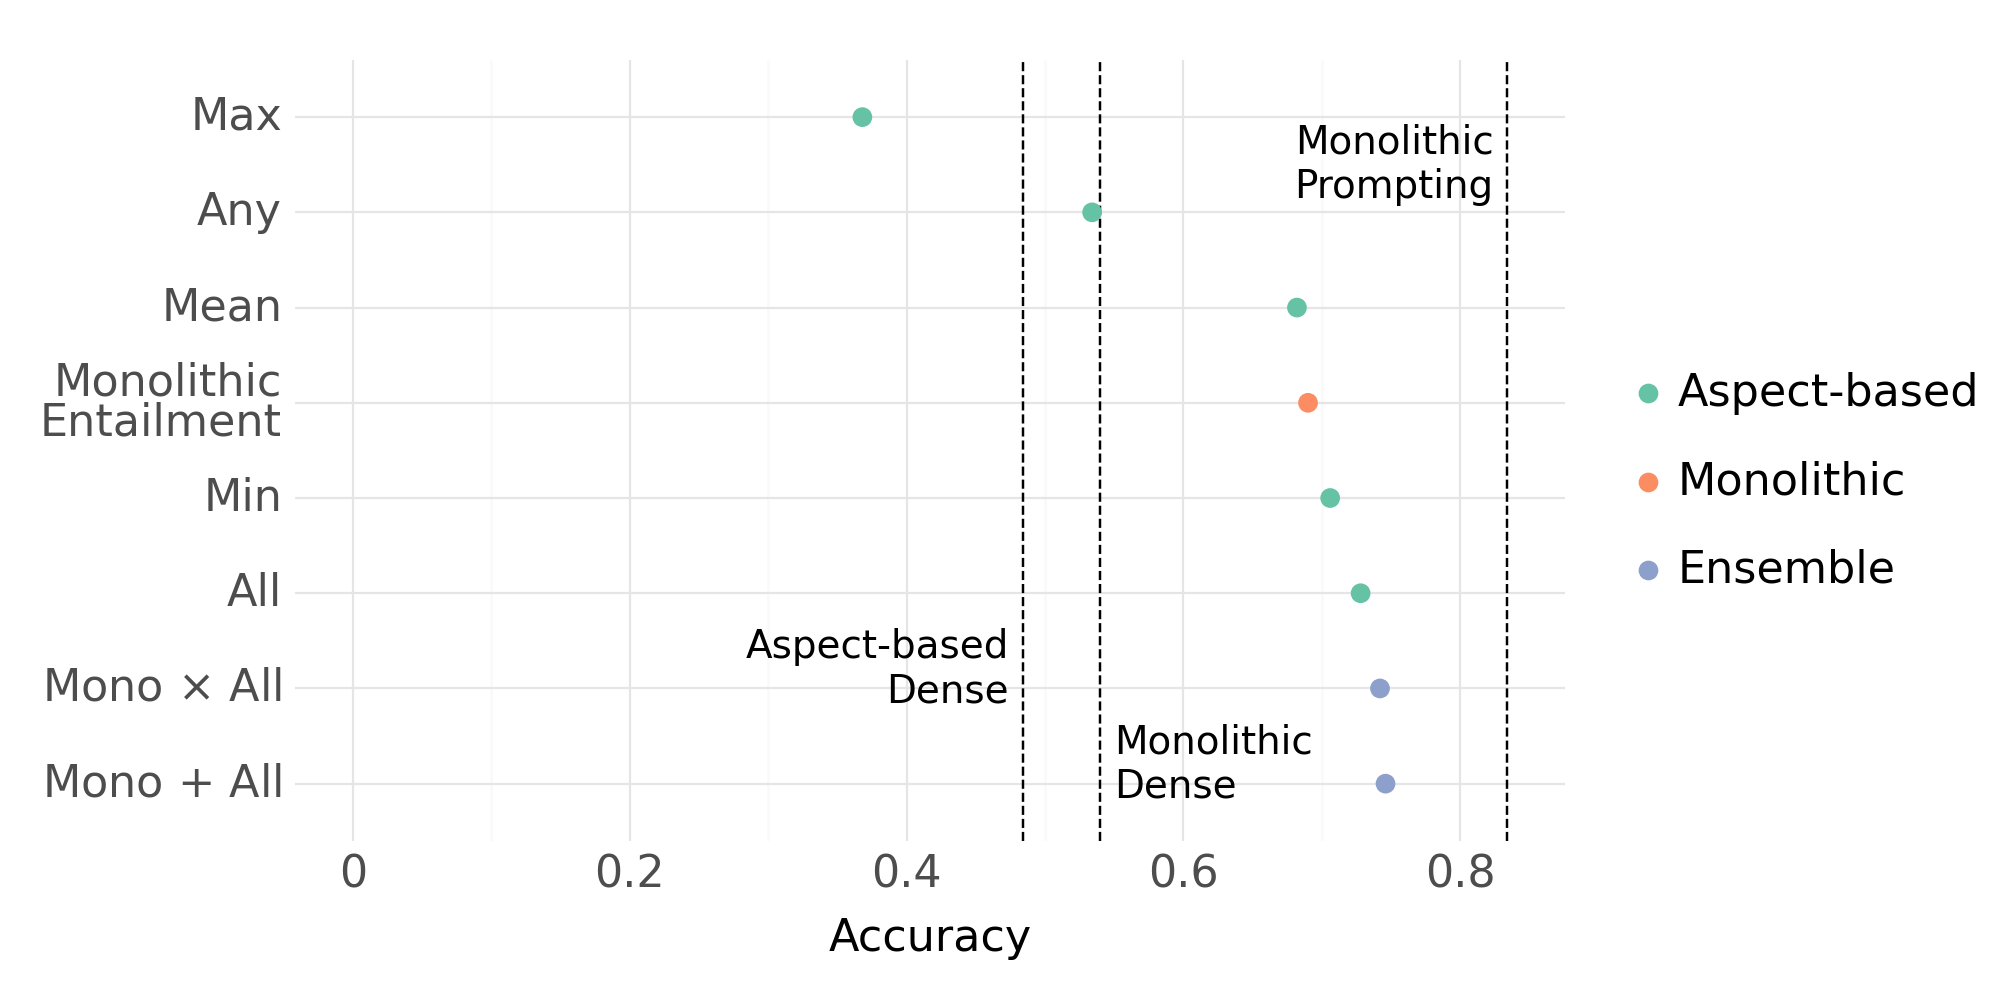

<Figure Size: (1000 x 500)>

In [10]:
from plotnine import *

p = (
    accuracy_results
    .pipe(pd.DataFrame)
    .reset_index()
    .assign(
        method_type = lambda d: np.select([d.method == 'monolithic', d['method'].str.startswith('mono_')], ['Monolithic', 'Ensemble'], 'Aspect-based'),
        method = lambda d: d['method'].str.capitalize().replace({
            'Mono_x_all': 'Mono $\\times$ All',
            'Mono_plus_all': 'Mono $+$ All',
            'Monolithic': 'Monolithic\nEntailment'
        })
    )
    .pipe(ggplot, mapping = aes(y = 'reorder(method, -accurate)', x = 'accurate', color = 'reorder(method_type, accurate)')) +
    geom_vline(xintercept = 0.484, linetype = "--") +
    geom_vline(xintercept = 0.54, linetype = "--") +
    geom_vline(xintercept = 0.834, linetype = "--") +
    geom_point(size = 3) +
    theme_minimal() +
    labs(y = "", x = "Accuracy", color = "") +
    xlim(0, None) +
    scale_color_brewer(type = "qual", palette = "Set2") +
    theme(figure_size=(10, 5), text=element_text(size=16), legend_entry_spacing_y=16) +
    annotate(geom="text", x=0.55, y=1.2, label="Monolithic\nDense", ha = "left", size = 14) +
    annotate(geom="text", x=0.824, y=7.5, label="Monolithic\nPrompting", ha = "right", size = 14) +
    annotate(geom="text", x=0.474, y=2.2, label="Aspect-based\nDense", ha = "right", size = 14)
)

p.save("RecipeMPR Results.png")

p